## Image Captioning Using Atttention Mechanism

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Importing Libraries**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.models import Model

keras = tf.keras


In [ ]:
max_cap_len = 15  #  max length of captioning sentences
img_dimension = 299 #  height and width of images
num_words = 10000 #  vocab size to tokenize and train on
encoding_size = 512 # dimension of the encodings of images
LSTM_size = 512
batch_size = 128
n_epochs = 15
Buffer_size = 1000 #shuffle
validation_and_test_split = 0.4
test_to_val_split = 0.8
num_examples = None # Determines number of overall read samples. If set to none all samples will be read as long as they don't exceed max_cap_len

### **Dataset Download**

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'

annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'

image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
PATH = os.path.dirname(image_zip) + image_folder
os.remove(image_zip)


13510574080/13510573713 [==============================] - 327s 0us/step


In [ ]:
print(PATH)

/content/train2014/


### **Pre-processing Captions**

In [ ]:
annotation_file = '/content/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = annot['caption']

    #Removing the word 'a' from captions
    caption = caption.replace(" a "," ")
    caption = caption.replace("A ","")
    #Removing the word 'an' from captions
    caption = caption.replace("An ","")
    caption = caption.replace(" an "," ")
    #Removing the word 'the' from captions
    caption = caption.replace(" the "," ")
    caption = caption.replace("The ","")

    #Load only captions that don't exceed maximum length
    if len(caption.split(" ")) > max_cap_len:
      continue
    else:
      caption = '<sos> ' + caption + ' <eos>'
      image_id = annot['image_id']
      full_coco_image_path = '/content/train2014/' + 'COCO_train2014_' + '%012d.jpg' % (image_id)

      all_img_name_vector.append(full_coco_image_path)
      all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

caption_train, captions_test, img_name_vector_train, img_name_vector_test = train_test_split(train_captions,
                                                                      img_name_vector,
                                                                      test_size= validation_and_test_split)

caption_val, caption_test, img_name_vector_val, img_name_vector_test = train_test_split(captions_test,
                                                        img_name_vector_test,
                                                        test_size= test_to_val_split)
num_samples = len(img_name_vector)
assert len(train_captions) == len(img_name_vector)
print("Loaded %d samples" %(num_samples))
print("Loaded %d train samples" %(len(caption_train)))
print("Loaded %d valid samples" %(len(caption_val)))
print("Loaded %d test samples" %(len(caption_test)))


Loaded 409297 samples
Loaded 245578 train samples
Loaded 32743 valid samples
Loaded 130976 test samples


In [ ]:
tok = keras.preprocessing.text.Tokenizer(num_words = num_words
                                         ,filters ="!?,'()_-+=&*$#@.",oov_token="<unk>")
tok.fit_on_texts(caption_train)
captions_train = tok.texts_to_sequences(caption_train)
if num_words == None:
  words = len(tok.word_index)
else:
  words = num_words
captions_train = keras.preprocessing.sequence.pad_sequences(captions_train, padding='post',maxlen=max_cap_len + 2)
print("Example:", captions_train[np.random.randint(low=0, high= len(captions_train) - 1)])
print("Found %d unique words" %(words))

Example: [  2  10  25 484 340 150  57   3   0   0   0   0   0   0   0   0   0]
Found 10000 unique words


In [ ]:
captions_valid = tok.texts_to_sequences(caption_val)
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path) #reads the file
  img = tf.image.decode_jpeg(img, channels=3) #decodes a JPEG-encoded image to a uint8 tensor. uint8 tensor:data type that contains all whole numbers from 0 to 255.
  img = tf.image.resize(img, (img_dimension, img_dimension)) #resizes to 299 by 299
  return img

In [ ]:
def preprocess_func(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_train,indices=path_index)
  img = load_img(path)
  #Preprocessing text
  teacher_caption = caption[:-1] #all words of the caption except <end>
  tar_caption = caption[1:] #all words of caption except <start
  
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption  

In [ ]:
def preprocess_func_val(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_val,indices=path_index)
  img = load_img(path)
  #Preprocessing text
  teacher_caption = caption[:-1] 
  tar_caption = caption[1:]   

  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [ ]:
#Creating an array to index each img path for reading 
path_index_vec_train = np.array(list(range(0,len(img_name_vector_train)))).reshape(-1,1) #index values from 0 to len(img_name_vector_train)reshaped to a column
path_index_vec_val = np.array(list(range(0,len(img_name_vector_val)))).reshape(-1,1)

dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train) #index values
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train) # sequenced captions
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train)) # each caption will be enumerated
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
captions_train[:5]

array([[   2,   16,   80, 3658,    6,  206,   33,    7,  117, 1578,  151,
           4,  213,    3,    0,    0,    0],
       [   2,   32,    5,   16,    7,  290,  453,   92,  410,    3,    0,
           0,    0,    0,    0,    0,    0],
       [   2,   21,   15,    4,   41,  536,  231,  100,    3,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,   58,  147,    9, 1564,    6,  131, 1147,  177,  178,    3,
           0,    0,    0,    0,    0,    0],
       [   2,   10, 4292,   14, 2089, 1426,  223,   82,  191,    3,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [ ]:
path_index_vec_train[:10]

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [8],
       [9]])

In [ ]:
for i in dataset1_train:
  print(i.numpy())
  break

[0]


In [ ]:
for i in dataset2_train:
  print(i.numpy())
  break

[   2   16   80 3658    6  206   33    7  117 1578  151    4  213    3
    0    0    0]


In [ ]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size,drop_remainder=True).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256,drop_remainder=True).prefetch(1)

### **Encoder Model**

In [ ]:
model = InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(299,299,3))


219062272/219055592 [==============================] - 1s 0us/step


In [ ]:
IncepResnet_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-1].output) 


In [ ]:
IncepResnet_extractor.trainable=False 

In [ ]:
#will change imagenet weights if not False
print(IncepResnet_extractor.summary())

In [ ]:
encoder = keras.models.Sequential([
                                   keras.layers.Lambda(preprocess_input,input_shape=(img_dimension,img_dimension,3),name="preprocessing_layer"), #Lambda layers are used for simple operations or quick experimentation.
                                   IncepResnet_extractor, #o/p of InceptionResnet
                                   keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer"),
                                   keras.layers.Reshape((8*8,encoding_size),name="reshape_layer")
],name="Encoder")
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_layer (Lambda) (None, 299, 299, 3)       0         
_________________________________________________________________
model (Functional)           (None, 8, 8, 1536)        54336736  
_________________________________________________________________
encoding_layer (Dense)       (None, 8, 8, 512)         786944    
_________________________________________________________________
reshape_layer (Reshape)      (None, 64, 512)           0         
Total params: 55,123,680
Trainable params: 786,944
Non-trainable params: 54,336,736
_________________________________________________________________


### **Attention Mechanism**

In [ ]:
W1 = keras.layers.Dense(512,name="W1") 
W2 = keras.layers.Dense(512,name="W2") 
V = keras.layers.Dense(1,name="V")
repeater = keras.layers.RepeatVector(8*8) 
doter = keras.layers.Dot(axes=1)
concatenator = keras.layers.Concatenate()

def attention_step(enc,h_prev):
  h = repeater(h_prev) 
  score = tf.nn.tanh(W1(enc)+ W2(h)) 
  alphas =tf.nn.softmax(V(score),axis=1) 

  context = doter([alphas,enc]) 
  return context

### **Decoder Model**

In [ ]:
encodings = keras.layers.Input(shape=(8*8,encoding_size))
    
init_h = keras.layers.Input(shape=(LSTM_size))
init_c = keras.layers.Input(shape=(LSTM_size))

teacher_forcing = keras.layers.Input(shape=(1))

embedding_layer = keras.layers.Embedding(words+1,256,)


context_prev_tar_concat_layer = keras.layers.Concatenate()
decoder_lstm_layer = keras.layers.LSTM(LSTM_size,return_state=True,dropout=0.2)
decoder_dense_layer = keras.layers.Dense(words+1,activation='softmax')

h = init_h

c = init_c

context = attention_step(encodings,h)

embedds = embedding_layer(teacher_forcing)

decoder_lstm_input = context_prev_tar_concat_layer([context,embedds])
  
  
h , _ , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(h)

decoder = keras.models.Model([encodings,init_h,init_c,teacher_forcing],[out,h,c])
decoder.summary()


NameError: ignored

In [ ]:
# to calculate loss function
# categorical cross entropy
# adam optimizer

def sparse_it_up(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  real = tf.cast(real,tf.int64)
  real = tf.one_hot(real,words+1,axis=-1)

  loss_ = tf.losses.categorical_crossentropy(real, pred)

  mask = tf.cast(mask, dtype=tf.float32)

  loss_ *= mask

  return tf.reduce_mean(loss_)


In [ ]:
# model training

optimizer = keras.optimizers.Adam()

@tf.function
def train_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [ ]:
# This function is for forward passing features for calculating losses with no backprop

@tf.function
def valid_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  return loss

### **Model Training**

In [ ]:
import time
EPOCHS = 5

prev_loss = np.inf #infinity 
loss_list = []

for epoch in range(EPOCHS): 
    start = time.time()
    total_loss = 0

    for (batch, ((img, s, teacher) ,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, s, teacher ,target)
        total_loss += t_loss

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    val_loss=0

    for (i, ((img, s, teacher) ,target)) in enumerate(dataset_val):
      val_loss += valid_step(img, s, teacher ,target)
    
    val_loss = val_loss.numpy()/((i+1)*(max_cap_len+1))
    print("val_loss=",val_loss)
    loss_list.append(val_loss)


    
    #This code makes sure we only save the best val_loss score weights
    if val_loss < prev_loss:
      print("Model_improved. Saving..")

      encoder.save("/content/drive/MyDrive/inception resnet_V2_5 epochs/5_encoder.hdf5")
      decoder.save("/content/drive/MyDrive/inception resnet_V2_5 epochs/5_decoder.hdf5")
    
    else:
      print("Model didn't improve.")

    prev_loss = val_loss

Epoch 1 Batch 0 Loss 5.4335
Epoch 1 Batch 50 Loss 3.4879
Epoch 1 Batch 100 Loss 3.5836
Epoch 1 Batch 150 Loss 3.4293
Epoch 1 Batch 200 Loss 3.2148
Epoch 1 Batch 250 Loss 3.1996
Epoch 1 Batch 300 Loss 2.8464
Epoch 1 Batch 350 Loss 2.5896
Epoch 1 Batch 400 Loss 2.5201
Epoch 1 Batch 450 Loss 2.3502
Epoch 1 Batch 500 Loss 2.3176
Epoch 1 Batch 550 Loss 2.3133
Epoch 1 Batch 600 Loss 2.1894
Epoch 1 Batch 650 Loss 2.1864
Epoch 1 Batch 700 Loss 2.2086
Epoch 1 Batch 750 Loss 2.2390
Epoch 1 Batch 800 Loss 2.1824
Epoch 1 Batch 850 Loss 2.1635
Epoch 1 Batch 900 Loss 2.0827
Epoch 1 Batch 950 Loss 2.1678
Epoch 1 Batch 1000 Loss 1.9347
Epoch 1 Batch 1050 Loss 2.1381
Epoch 1 Batch 1100 Loss 2.1741
Epoch 1 Batch 1150 Loss 2.0485
Epoch 1 Batch 1200 Loss 2.0127
Epoch 1 Batch 1250 Loss 2.0927
Epoch 1 Batch 1300 Loss 1.9004
Epoch 1 Batch 1350 Loss 1.9713
Epoch 1 Batch 1400 Loss 1.8923
Epoch 1 Batch 1450 Loss 1.9839
Epoch 1 Batch 1500 Loss 1.9413
Epoch 1 Batch 1550 Loss 1.9130
Epoch 1 Batch 1600 Loss 1.9439


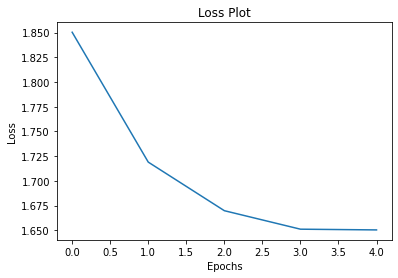

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.savefig('val_loss.png')

In [ ]:
# Loading 
encoder.load_weights("/content/drive/MyDrive/inception resnet_V2_5 epochs/5_encoder.hdf5")
decoder.load_weights("/content/drive/MyDrive/inception resnet_V2_5 epochs/5_decoder.hdf5")

OSError: ignored

In [ ]:
def caption_image(path):
  image = load_img(path)

  encodings = encoder.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  print(' '.join(texts))
  plt.imshow(image/255.0)
  plt.axis("off")
  

In [ ]:
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM.jpeg')

<sos> a potted plant in some plants and plants <eos>


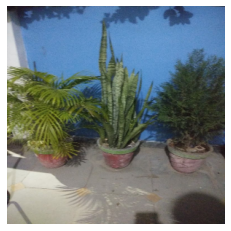

In [ ]:
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (5).jpeg')

<sos> plant in vase on table <eos>


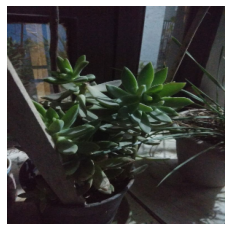

In [ ]:
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (4).jpeg')

<sos> a plant in garden pot on table <eos>


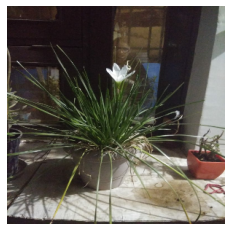

In [ ]:
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (3).jpeg')

<sos> a close up of metal rail on metal bench <eos>


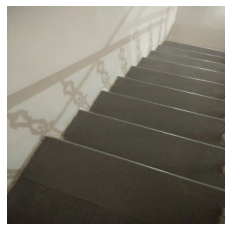

In [ ]:
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (2).jpeg')

<sos> pair of scissors sitting on top of wooden table <eos>


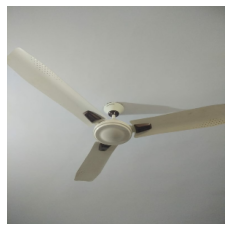

In [ ]:
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (1).jpeg')

<sos> a close up of some food in plastic containers <eos>


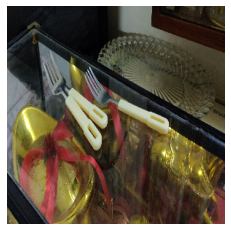

In [ ]:
caption_image('/content/IMG_20201208_191934.jpg')

<sos> computer desk with computer on top <eos>


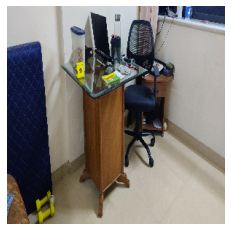

In [ ]:
caption_image('/content/IMG_20201208_191917.jpg')

<sos> man on remote in side <eos>


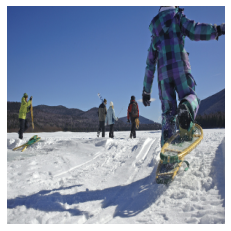

In [ ]:
caption_image(img_name_vector_test[20])

<sos> sidewalk with parking and parking in it <eos>


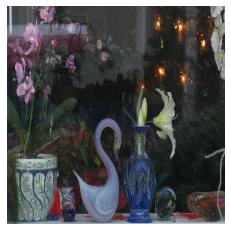

In [ ]:
caption_image(img_name_vector_test[111])

<sos> woman sitting on wall bench with laying van level <eos>


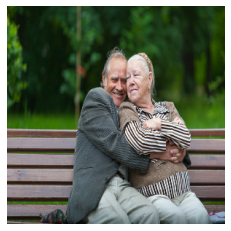

In [ ]:
caption_image(img_name_vector_test[1700])

<sos> kitchen with luggage and brown <eos>


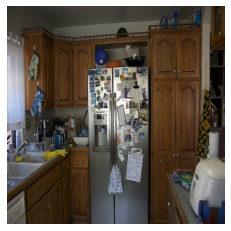

In [ ]:
caption_image(img_name_vector_test[9888])

In [ ]:
caption_image(img_name_vector_test[129])

<sos> visitor s launch with desks and boats in front of track <eos>


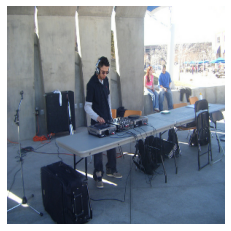

In [ ]:
caption_image(img_name_vector_test[600])

<sos> platform of man and fence picture <eos>


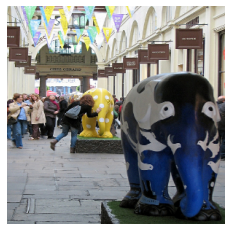

In [ ]:
caption_image(img_name_vector_test[2048])

<sos> covered is there next to horses man <eos>


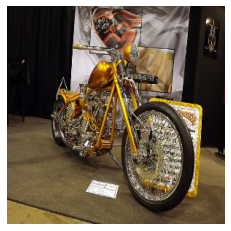

In [ ]:
caption_image(img_name_vector_test[12])

<sos> court sign is lift on top of court sign <eos>


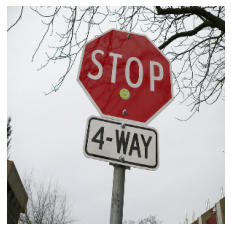

In [ ]:
caption_image(img_name_vector_test[906])

<sos> court sign is in ready of shot <eos>


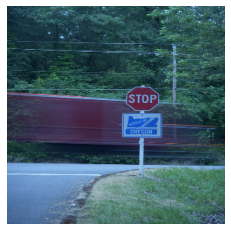

In [ ]:
caption_image(img_name_vector_test[929])

<sos> a dog sitting on from bench with his tile on from bench <eos>


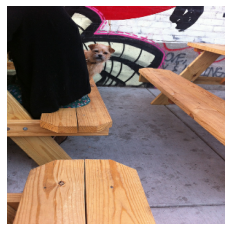

In [ ]:
caption_image(img_name_vector_test[873])

# ran now
caption_image(img_name_vector_test[2000])

<sos> bear is sitting in basket with basket on it <eos>


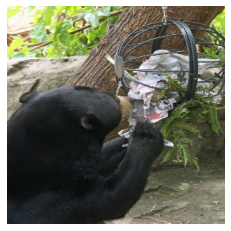

In [ ]:
# ran now
caption_image(img_name_vector_test[1100])

<sos> street sign on corner of street <eos>


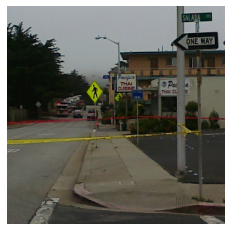

In [ ]:
# ran now
caption_image(img_name_vector_test[3000])

<sos> motorcycle parked on side of road <eos>


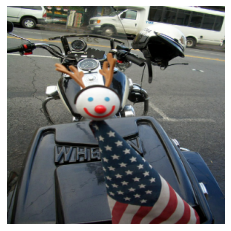

In [ ]:
# ran now
caption_image(img_name_vector_test[99])

<sos> cat standing on floor next to dog <eos>


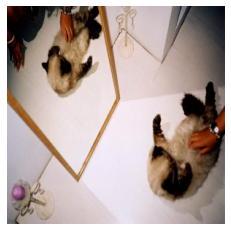

In [ ]:
# ran now
caption_image(img_name_vector_test[11])

<sos> table with plates of food and cup of coffee <eos>


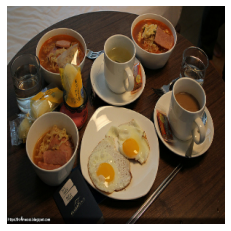

In [ ]:
# ran now
caption_image(img_name_vector_test[188])

<sos> yellow fire hydrant on gravel road <eos>


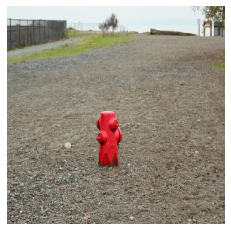

In [ ]:
# ran now
caption_image(img_name_vector_test[808])

<sos> cat laying on bed with white comforter <eos>


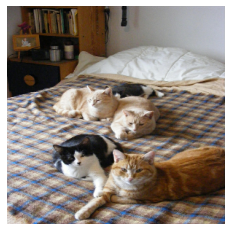

In [ ]:
# ran now
caption_image(img_name_vector_test[3])

<sos> people standing around luggage carousel at airport <eos>


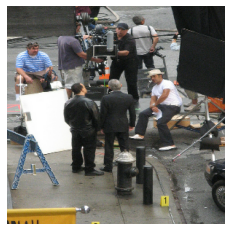

In [ ]:
# ran now
caption_image(img_name_vector_test[16])

<sos> a close up of some kind of some type of old fashioned <eos>


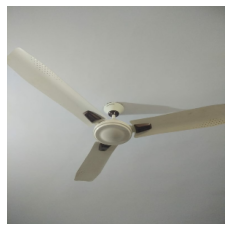

In [ ]:
# ran now
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (1).jpeg')

<sos> a window field of some type of some fighter of open team <eos>


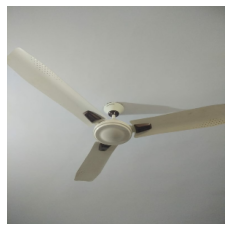

In [ ]:
# load_weights
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (1).jpeg')

<sos> a person on skate board on some steps <eos>


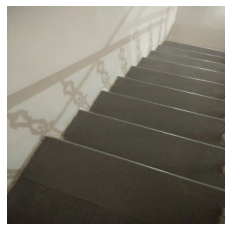

In [ ]:
# ran now
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (2).jpeg')

<sos> a person on signs phone on some bite <eos>


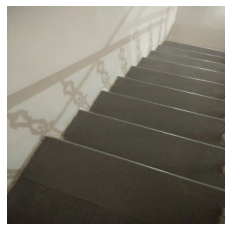

In [ ]:
# load_weight
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (2).jpeg')

<sos> a green plant in tree with some plants in it <eos>


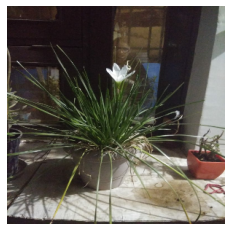

In [ ]:
# ran now
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (3).jpeg')

<sos> a pizza modern in as with some shop in it <eos>


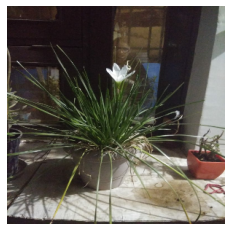

In [ ]:
# load_weight
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (3).jpeg')

<sos> a pizza modern in as with some shop in it <eos>


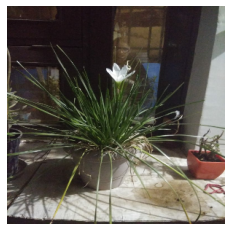

In [ ]:
# load_weight
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (3).jpeg')

<sos> a planter with some plants and flowers in it <eos>


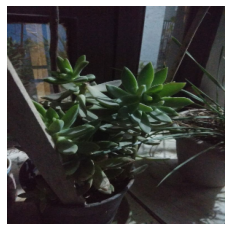

In [ ]:
# ran now
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (4).jpeg')

<sos> a bunch of plants that are sitting in front of tree <eos>


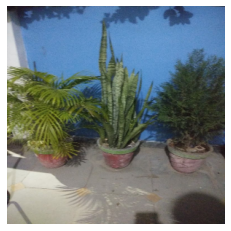

In [ ]:
# ran now
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM (5).jpeg')

<sos> a close up of mirror in window sill <eos>


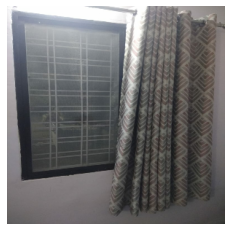

In [ ]:
# ran now
caption_image('/content/WhatsApp Image 2020-12-08 at 7.21.46 PM.jpeg')

<sos> a desk with laptop and keyboard <eos>


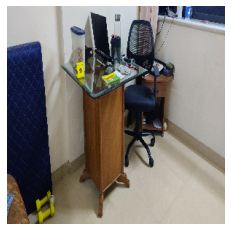

In [ ]:
# ran now
caption_image('/content/IMG_20201208_191917.jpg')

<sos> a close up of hot dog and some food <eos>


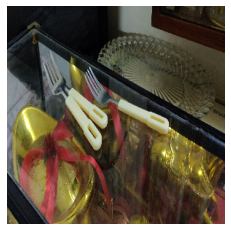

In [ ]:
# ran now
caption_image('/content/IMG_20201208_191934.jpg')

In [ ]:
len(img_name_vector_test)
len(caption_test)

130976

##Evaluation 

In [ ]:
def caption_image_BLEU(path):
  image = load_img(path)

  encodings = encoder.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  prediction = ' '.join(texts)
  plt.imshow(image/255.0)
  plt.axis("off")
  return prediction

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_model(encoder,decoder, img_name_vector_val2, caption_val2, log=False):
    actual, predicted = list(), list()
    # step over the whole set
    i=0
    counter = 0
    for key, desc_list in zip(img_name_vector_val2, caption_val2):
        # generate description
        i+=1
        #progressBar(i, len(caption_val), bar_length=20,job='Evaluating')
        pred = caption_image_BLEU(key)
        # store actual and predicted
        references = desc_list.split()
        actual.append(references)
        predicted.append(pred.split())
        counter = counter+1
        if counter%100 == 0:
            print(counter)
           
    # calculate BLEU score
    print("HERE")
    b1=corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b2=corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    b3=corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    b4=corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\n')
    print('BLEU-1: %f' % b1)
    print('BLEU-2: %f' % b2)
    print('BLEU-3: %f' % b3)
    print('BLEU-4: %f' % b4)
    return [b1, b2, b3, b4]

b1, b2, b3, b4 = evaluate_model(encoder,decoder, img_name_vector_test, caption_test)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200


KeyboardInterrupt: ignored